In [1]:
#Group 24--- Machine Learning Course, Tilburg University, Block II/2019-2020
#ML Speech Classification Challenge

#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, BatchNormalization, MaxPooling1D, Dropout
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, recall_score, precision_score

In [2]:
#Import the data
b = np.load('feat.npy', allow_pickle = True)
path = np.load('path.npy', allow_pickle = True)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#Import MFCC files and merge with train data
df_npy = pd.DataFrame()
df_npy['Mel Freq'] = b
df_npy['Audiofile'] = path

train = train.rename(columns={"path": "Audiofile", "word": "Target"})
df_train = df_npy.merge(train, on="Audiofile", how = 'inner')
mel = df_train["Mel Freq"]
mel_np = np.array(mel)

In [46]:
#Empty array for padding the features
newarray = np.zeros([94824,99,13])

In [47]:
for index, y in enumerate(mel_np):
    for i, u in enumerate(y):
        for j, o in enumerate(u):
            newarray[index][i][j] = o
            
mel_freq = newarray

In [49]:
#Target labels
targets = []
target = df_train["Target"]
for t in target:
    targets.append(t)

In [50]:
#Splitting the dataset into a train and test set
X = mel_freq
y = targets 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [51]:
# One-hot Indicator array for classes
onehot = LabelBinarizer()
Y_train = onehot.fit_transform(y_train)

label_encoder = LabelEncoder()
integer_encoded_y_val = label_encoder.fit_transform(y_val)

In [52]:
#Transform the labels
y_val = to_categorical(integer_encoded_y_val)

In [53]:
#Using Early Stopping to reduce overfitting
checkpoint = ModelCheckpoint(filepath = 'bestmodel.hdf5', mode='auto', save_best_only=True,
                             restore_best_weights=True, verbose=1)
Early_Stopping = EarlyStopping(monitor='val_accuracy', patience=30)

In [54]:
#Defining callbacks and our validation set
callbacks = [Early_Stopping, checkpoint]
validation= [X_val, y_val]

In [55]:
#Model
input_shape = X_train[0].shape #99, 13

model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 8, activation='relu', input_shape = input_shape))
model.add(MaxPooling1D(13))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(435, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(335))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(235))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(135))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(35, activation='softmax'))

#optimizer = Adam(lr=0.003)

model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics = ['accuracy'])
final_model = model.fit(X_train, Y_train, epochs=150, batch_size=60, verbose=1, 
                        validation_data=validation,callbacks=callbacks)

Train on 85341 samples, validate on 9483 samples
Epoch 1/150
85320/85341 [============================>.] - ETA: 0s - loss: 2.4929 - accuracy: 0.3117
Epoch 00001: val_loss improved from inf to 1.83912, saving model to bestmodel.hdf5
85341/85341 [==============================] - 156s 2ms/sample - loss: 2.4927 - accuracy: 0.3117 - val_loss: 1.8391 - val_accuracy: 0.5180
Epoch 2/150
85320/85341 [============================>.] - ETA: 0s - loss: 2.0024 - accuracy: 0.4351
Epoch 00002: val_loss improved from 1.83912 to 1.55558, saving model to bestmodel.hdf5
85341/85341 [==============================] - 151s 2ms/sample - loss: 2.0024 - accuracy: 0.4350 - val_loss: 1.5556 - val_accuracy: 0.5912
Epoch 3/150
85320/85341 [============================>.] - ETA: 0s - loss: 1.7849 - accuracy: 0.4936
Epoch 00003: val_loss improved from 1.55558 to 1.38124, saving model to bestmodel.hdf5
85341/85341 [==============================] - 161s 2ms/sample - loss: 1.7848 - accuracy: 0.4936 - val_loss: 1.38

Epoch 26/150
85320/85341 [============================>.] - ETA: 0s - loss: 1.0173 - accuracy: 0.7016
Epoch 00026: val_loss improved from 0.74380 to 0.73489, saving model to bestmodel.hdf5
85341/85341 [==============================] - 146s 2ms/sample - loss: 1.0172 - accuracy: 0.7016 - val_loss: 0.7349 - val_accuracy: 0.7948
Epoch 27/150
85320/85341 [============================>.] - ETA: 0s - loss: 1.0055 - accuracy: 0.7053
Epoch 00027: val_loss improved from 0.73489 to 0.72675, saving model to bestmodel.hdf5
85341/85341 [==============================] - 147s 2ms/sample - loss: 1.0055 - accuracy: 0.7053 - val_loss: 0.7267 - val_accuracy: 0.7953
Epoch 28/150
85320/85341 [============================>.] - ETA: 0s - loss: 1.0013 - accuracy: 0.7064
Epoch 00028: val_loss improved from 0.72675 to 0.72118, saving model to bestmodel.hdf5
85341/85341 [==============================] - 147s 2ms/sample - loss: 1.0014 - accuracy: 0.7064 - val_loss: 0.7212 - val_accuracy: 0.7984
Epoch 29/150
853

Epoch 51/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.8670 - accuracy: 0.7425
Epoch 00051: val_loss improved from 0.61565 to 0.61195, saving model to bestmodel.hdf5
85341/85341 [==============================] - 143s 2ms/sample - loss: 0.8670 - accuracy: 0.7425 - val_loss: 0.6119 - val_accuracy: 0.8260
Epoch 52/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.8616 - accuracy: 0.7469
Epoch 00052: val_loss improved from 0.61195 to 0.60873, saving model to bestmodel.hdf5
85341/85341 [==============================] - 143s 2ms/sample - loss: 0.8616 - accuracy: 0.7469 - val_loss: 0.6087 - val_accuracy: 0.8279
Epoch 53/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.8587 - accuracy: 0.7469
Epoch 00053: val_loss improved from 0.60873 to 0.60655, saving model to bestmodel.hdf5
85341/85341 [==============================] - 142s 2ms/sample - loss: 0.8588 - accuracy: 0.7469 - val_loss: 0.6066 - val_accuracy: 0.8277
Epoch 54/150
853

Epoch 76/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.7849 - accuracy: 0.7668
Epoch 00076: val_loss improved from 0.55484 to 0.55245, saving model to bestmodel.hdf5
85341/85341 [==============================] - 141s 2ms/sample - loss: 0.7849 - accuracy: 0.7667 - val_loss: 0.5525 - val_accuracy: 0.8409
Epoch 77/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.7842 - accuracy: 0.7657
Epoch 00077: val_loss improved from 0.55245 to 0.55130, saving model to bestmodel.hdf5
85341/85341 [==============================] - 140s 2ms/sample - loss: 0.7842 - accuracy: 0.7657 - val_loss: 0.5513 - val_accuracy: 0.8408
Epoch 78/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.7806 - accuracy: 0.7683
Epoch 00078: val_loss improved from 0.55130 to 0.54947, saving model to bestmodel.hdf5
85341/85341 [==============================] - 141s 2ms/sample - loss: 0.7807 - accuracy: 0.7683 - val_loss: 0.5495 - val_accuracy: 0.8416
Epoch 79/150
853

Epoch 101/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.7354 - accuracy: 0.7793
Epoch 00101: val_loss improved from 0.51753 to 0.51647, saving model to bestmodel.hdf5
85341/85341 [==============================] - 140s 2ms/sample - loss: 0.7354 - accuracy: 0.7793 - val_loss: 0.5165 - val_accuracy: 0.8525
Epoch 102/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.7327 - accuracy: 0.7806
Epoch 00102: val_loss improved from 0.51647 to 0.51360, saving model to bestmodel.hdf5
85341/85341 [==============================] - 142s 2ms/sample - loss: 0.7327 - accuracy: 0.7806 - val_loss: 0.5136 - val_accuracy: 0.8526
Epoch 103/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.7291 - accuracy: 0.7823
Epoch 00103: val_loss improved from 0.51360 to 0.51335, saving model to bestmodel.hdf5
85341/85341 [==============================] - 142s 2ms/sample - loss: 0.7291 - accuracy: 0.7823 - val_loss: 0.5133 - val_accuracy: 0.8519
Epoch 104/150

Epoch 126/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.6962 - accuracy: 0.7921 ETA: 0s - loss: 0.6964 - accuracy - ETA: 0s - loss: 0.6966 - accuracy: 
Epoch 00126: val_loss improved from 0.49000 to 0.48976, saving model to bestmodel.hdf5
85341/85341 [==============================] - 140s 2ms/sample - loss: 0.6963 - accuracy: 0.7920 - val_loss: 0.4898 - val_accuracy: 0.8571
Epoch 127/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.6969 - accuracy: 0.7920
Epoch 00127: val_loss improved from 0.48976 to 0.48877, saving model to bestmodel.hdf5
85341/85341 [==============================] - 141s 2ms/sample - loss: 0.6971 - accuracy: 0.7920 - val_loss: 0.4888 - val_accuracy: 0.8573
Epoch 128/150
85320/85341 [============================>.] - ETA: 0s - loss: 0.6979 - accuracy: 0.7916
Epoch 00128: val_loss improved from 0.48877 to 0.48740, saving model to bestmodel.hdf5
85341/85341 [==============================] - 141s 2ms/sample - loss: 0.6979 - 

In [56]:
model.load_weights("bestmodel.hdf5")

In [64]:
#Calcuting accuracy and loss
score = model.evaluate(X_val, y_val, verbose=0)

print('Validation loss:',score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.47049232588266376
Validation accuracy: 0.8625962


In [69]:
y_pred = model.predict_classes(X_val,verbose = False)
y_pred = to_categorical(y_pred)

In [70]:
#Creating 1D arrays to plot
y_val_plt = y_val.argmax(axis=1)
y_pred_plt = y_pred.argmax(axis=1)

#Visualize the expected vs the predicted output
output = pd.DataFrame()
output['Expected Output'] = y_val_plt
output['Predicted Output'] = y_pred_plt
#output.head(10)

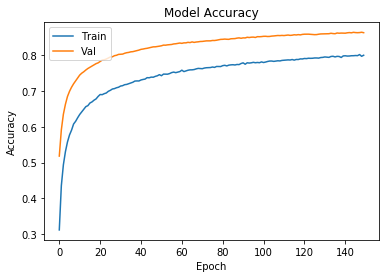

In [71]:
#Plotting train vs validation accuracy
history = final_model 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

[]

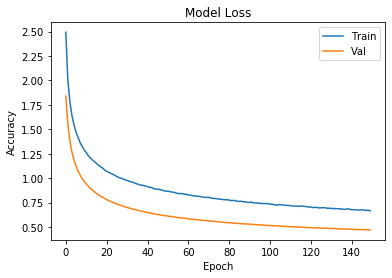

In [72]:
#Plotting train vs validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.plot()

In [74]:
#Calculating precision
print(precision_score(y_val, y_pred, average = 'macro'))

#Calculating recall
print(recall_score(y_val, y_pred, average = 'macro'))

0.8611602785085283
0.8484495829784474


In [75]:
#Merge the test set with MFCC files
test = test.rename(columns={"path": "Audiofile"})
df_test = test.merge(df_npy, on="Audiofile", how = 'inner')
mel_test = df_test["Mel Freq"]
mel_np_test = np.array(mel_test)

In [78]:
#Zero array for padding for the test set
newarray = np.zeros([11005,99,13])

for index, y in enumerate(mel_np_test):
    for i, u in enumerate(y):
        for j, o in enumerate(u):
            newarray[index][i][j] = o
            
test_array = newarray 

In [79]:
#Use the model the make predictions on the test set
y_test = model.predict_classes(test_array)
results = label_encoder.inverse_transform(y_test)

final = pd.DataFrame()
final["path"] = df_test["Audiofile"]
final["word"] = results

In [81]:
output.head(10)

,Expected Output,Predicted Output
0,15,15
1,3,33
2,22,22
3,1,2
4,5,5
5,14,20
6,22,22
7,15,15
8,34,34
9,17,17


In [ ]:
#Create the final results.csv file
final.to_csv('result.csv', index=False)